https://raposa.trade/blog/higher-highs-lower-lows-and-calculating-price-trends-in-python/

What happens if the price direction disagrees with your model? For example, the price may be increasing, but your RSI - a derivative of price - is decreasing. Should you trade this if you get a signal? Or could you use this disagreement itself as a signal?

Situations like this are referred to as divergences because the price and the indicator are moving in opposite directions. Typically you'll see traders discuss price making a "higher high" while some indicator makes a "lower low." In technical analysis, traders will call this a bearish divergence and they'll forecast a price drop. The opposite situation indicates a bullish divergence, leading to a forecasted price rise.

We don't really care what the forecast is - we want to see if there are any statistical signals we can extract from this pattern. To that end, we need a formula to capture these movements.



### What makes a Peak?

Having a computer spot a peak or trough is actually more difficult than it may seem.

Take a look at the plot below. What would you call a "peak?"

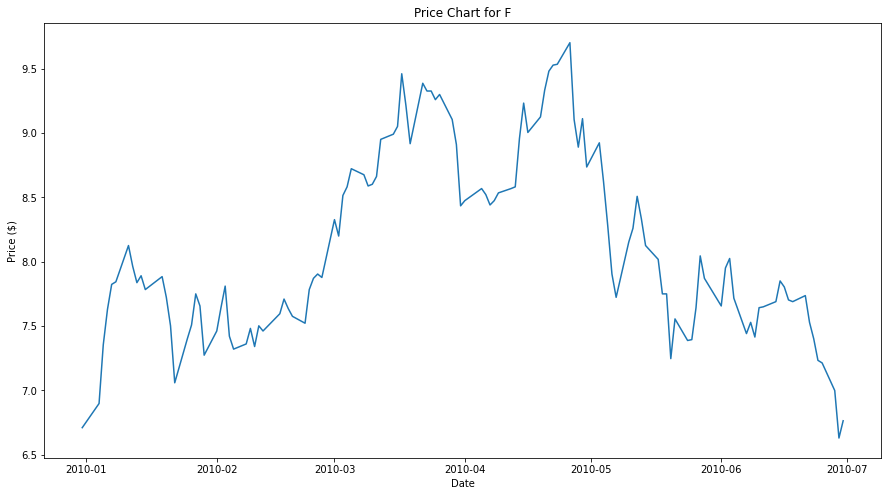

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

ticker = 'F'
yfObj = yf.Ticker(ticker)
data = yfObj.history(start='2010-01-01', end='2010-07-01')

plt.figure(figsize=(15, 8))
plt.plot(data['Close'])
plt.title(f'Price Chart for {ticker}')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.show()

We have local maxima and minima - points that are higher or lower than either of the points immediately to the left and right - scattered throughout the chart.

Clearly the peak - or the global maximum over this range - occurs on April 26th when the price closes at $9.80. But would you count the prices on April 5th or April 15th? They are local maxima, but does that make them peaks to mark a divergence? If not, why not? And when would you know?



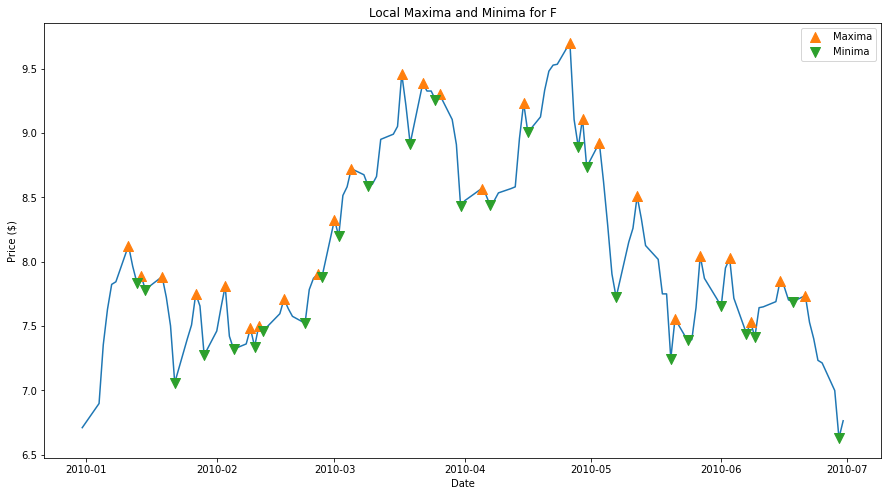

In [2]:
data['local_max'] = data['Close'][
  (data['Close'].shift(1) < data['Close']) &
  (data['Close'].shift(-1) < data['Close'])]

data['local_min'] = data['Close'][
  (data['Close'].shift(1) > data['Close']) &
  (data['Close'].shift(-1) > data['Close'])]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(figsize=(15, 8))
plt.plot(data['Close'], zorder=0)
plt.scatter(data.index, data['local_max'], s=100,
  label='Maxima', marker='^', c=colors[1])
plt.scatter(data.index, data['local_min'], s=100,
  label='Minima', marker='v', c=colors[2])
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title(f'Local Maxima and Minima for {ticker}')
plt.legend()
plt.show()

We need to do some kind of filtering or develop some type of rules to identify peaks and troughs so we don't end up with such a noisy signal like we have in the plot above. Additionally, we need to make sure we aren't looking ahead in our data when doing so.

One of the biggest issues with backtesting (and it is a particularly pernicious problem when dealing with divergences) is lookahead bias. You need to be certain that your test does not take into account data that it would not have had at the time.

For example, if we're trading Ford in April of 2010, and we get to a new high of $9.80 on April 26th, we don't actually know if that is a peak or not. It happens to drop 6% the next day and continue downward for most of the next month - but from the perspective of a trader on the 26th, we have no idea what will happen next. Whatever rule we implement in our algorithmic strategy has to take this into account and cannot trade on the 26th because it's a peak - that would be lookahead bias and would skew your results terribly.

Further, we have one more complication, we aren't just looking for new peaks and troughs, but a succession of peaks and troughs to make a divergence indicator. To extract "higher highs" out of a signal, we need at least two peaks with the second peak being higher than the first.

### Coding a Convergence/Divergence Indicator

For our purposes, we can use the argrelextrema function from SciPy's signal processing library.

This function will give us the max and min values from a time series. We simply need to pass our data, tell it whether we're looking for maxima or minima values, and then indicate how many data points to either side we're going to look. As shown above, we don't necessarily want to get every local max/min, instead we can look in wider areas to pull out peaks for our divergence indicator.

Take a look at the example below where we wait for 5 data points (order argument) to make our selection.

In [3]:
from scipy.signal import argrelextrema

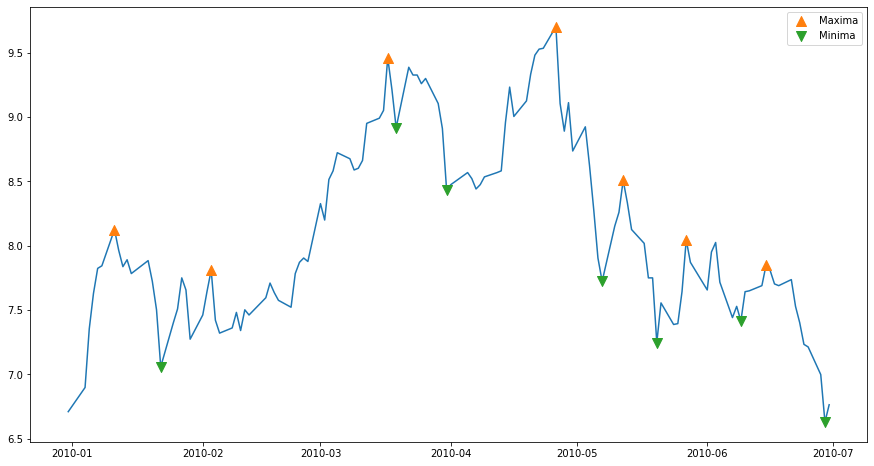

In [7]:
order = 5

max_idx = argrelextrema(data['Close'].values, np.greater, order=order)[0]
min_idx = argrelextrema(data['Close'].values, np.less, order=order)[0]
plt.figure(figsize=(15, 8))
plt.plot(data['Close'], zorder=0)
plt.scatter(data.iloc[max_idx].index, data.iloc[max_idx]['Close'],
  label='Maxima', s=100, color=colors[1], marker='^')
plt.scatter(data.iloc[min_idx].index, data.iloc[min_idx]['Close'],
  label='Minima', s=100, color=colors[2], marker='v')

plt.legend()
plt.show()

This plot looks much more like what we'd expect when pulling out peaks and troughs.

### Get Consecutive Peaks
Our next step is going to look for consecutive peaks or troughs so we can get "higher highs", "lower lows", "lower highs", or "higher lows". Ultimately we'll have four different cases to look for which will all follow very similar logic. Right now, let's just look cases where there are at least two consecutive "higher highs."

To do this, we're going to have to loop over our indices and check the values against the previous result. If the new peak is greater than the previous peak, we can append it to a list and move on, otherwise we start over with this new peak and look at the next one.



In [10]:
from collections import deque
# Get K consecutive higher peaks
K = 2
high_idx = argrelextrema(data['Close'].values, np.greater, order=5)[0]
highs = data.iloc[high_idx]['Close']

extrema = []
ex_deque = deque(maxlen=K)
for i, idx in enumerate(high_idx):
    if i == 0:
        ex_deque.append(idx)
        continue
    if highs[i] < highs[i-1]:
        ex_deque.clear()
    ex_deque.append(idx)
    if len(ex_deque) == K:
        # K-consecutive higher highs found
        extrema.append(ex_deque.copy())

From the plot above, we should find two sets of consecutive peaks with K=2. And printing out our extrema list, that's what we see.



In [11]:
print(extrema)

[deque([22, 51], maxlen=2), deque([51, 78], maxlen=2)]


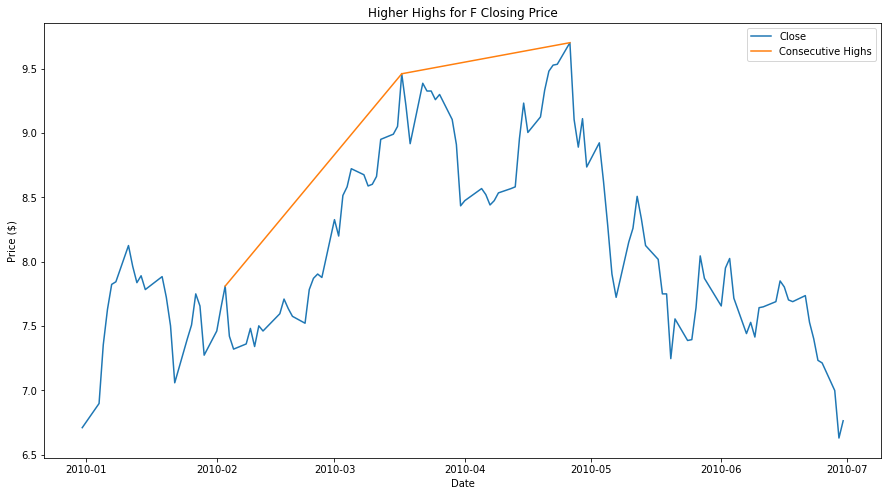

In [12]:
close = data['Close'].values
dates = data.index

plt.figure(figsize=(15, 8))
plt.plot(data['Close'])
_ = [plt.plot(dates[i], close[i], c=colors[1]) for i in extrema]
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title(f'Higher Highs for {ticker} Closing Price')
plt.legend(['Close', 'Consecutive Highs'])
plt.show()

We've pulled out our consecutive highs, so now let's put some functions together to get lower lows, lower highs, and higher lows.



In [23]:
def getHigherLows(data: np.array, order=5, K=2):
    '''
    Finds consecutive higher lows in price pattern.
    Must not be exceeded within the number of periods indicated by the width 
    parameter for the value to be confirmed.
    K determines how many consecutive lows need to be higher.
    '''
    # Get lows
    low_idx = argrelextrema(data, np.less, order=order)[0]
    lows = data[low_idx]
    # Ensure consecutive lows are higher than previous lows
    extrema = []
    ex_deque = deque(maxlen=K)
    for i, idx in enumerate(low_idx):
        if i == 0:
            ex_deque.append(idx)
            continue
        if lows[i] < lows[i-1]:
            ex_deque.clear()

        ex_deque.append(idx)
        if len(ex_deque) == K:
            extrema.append(ex_deque.copy())
    return extrema

def getLowerHighs(data: np.array, order=5, K=2):
    '''
    Finds consecutive lower highs in price pattern.
    Must not be exceeded within the number of periods indicated by the width 
    parameter for the value to be confirmed.
    K determines how many consecutive highs need to be lower.
    '''
    # Get highs
    high_idx = argrelextrema(data, np.greater, order=order)[0]
    highs = data[high_idx]
    # Ensure consecutive highs are lower than previous highs
    extrema = []
    ex_deque = deque(maxlen=K)
    for i, idx in enumerate(high_idx):
        if i == 0:
            ex_deque.append(idx)
            continue
        if highs[i] > highs[i-1]:
            ex_deque.clear()

        ex_deque.append(idx)
        if len(ex_deque) == K:
            extrema.append(ex_deque.copy())

    return extrema

def getHigherHighs(data: np.array, order=5, K=2):
    '''
    Finds consecutive higher highs in price pattern.
    Must not be exceeded within the number of periods indicated by the width 
    parameter for the value to be confirmed.
    K determines how many consecutive highs need to be higher.
    '''
    # Get highs
    high_idx = argrelextrema(data, np.greater, order=5)[0]
    highs = data[high_idx]
    # Ensure consecutive highs are higher than previous highs
    extrema = []
    ex_deque = deque(maxlen=K)
    for i, idx in enumerate(high_idx):
        if i == 0:
            ex_deque.append(idx)
            continue
        if highs[i] < highs[i-1]:
            ex_deque.clear()

        ex_deque.append(idx)
        if len(ex_deque) == K:
            extrema.append(ex_deque.copy())

    return extrema

def getLowerLows(data: np.array, order=5, K=2):
    '''
    Finds consecutive lower lows in price pattern.
    Must not be exceeded within the number of periods indicated by the width 
    parameter for the value to be confirmed.
    K determines how many consecutive lows need to be lower.
    '''
    # Get lows
    low_idx = argrelextrema(data, np.less, order=order)[0]
    lows = data[low_idx]
    # Ensure consecutive lows are lower than previous lows
    extrema = []
    ex_deque = deque(maxlen=K)
    for i, idx in enumerate(low_idx):
        if i == 0:
            ex_deque.append(idx)
            continue
        if lows[i] > lows[i-1]:
            ex_deque.clear()

        ex_deque.append(idx)
        if len(ex_deque) == K:
            extrema.append(ex_deque.copy())

    return extrema

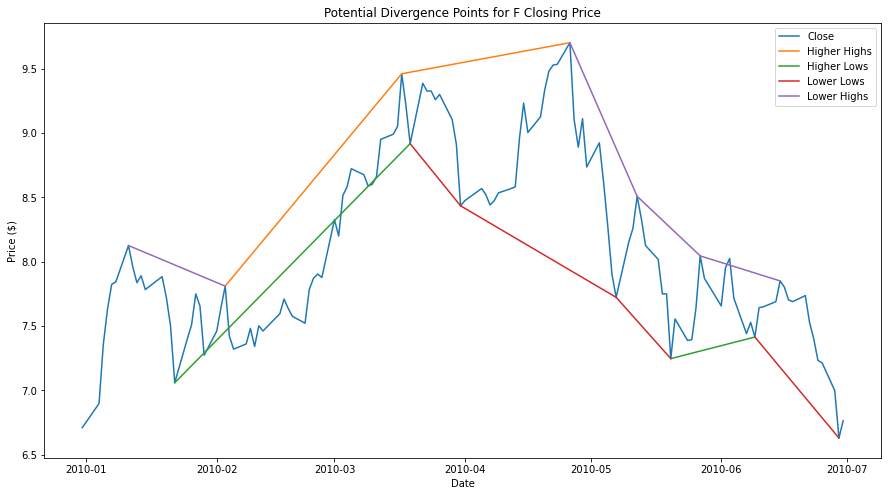

In [24]:
from matplotlib.lines import Line2D

close = data['Close'].values
dates = data.index

order = 5
K = 2

hh = getHigherHighs(close, order, K)
hl = getHigherLows(close, order, K)
ll = getLowerLows(close, order, K)
lh = getLowerHighs(close, order, K)

plt.figure(figsize=(15, 8))
plt.plot(data['Close'])
_ = [plt.plot(dates[i], close[i], c=colors[1]) for i in hh]
_ = [plt.plot(dates[i], close[i], c=colors[2]) for i in hl]
_ = [plt.plot(dates[i], close[i], c=colors[3]) for i in ll]
_ = [plt.plot(dates[i], close[i], c=colors[4]) for i in lh]
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title(f'Potential Divergence Points for {ticker} Closing Price')
legend_elements = [
  Line2D([0], [0], color=colors[0], label='Close'),
  Line2D([0], [0], color=colors[1], label='Higher Highs'),
  Line2D([0], [0], color=colors[2], label='Higher Lows'),
  Line2D([0], [0], color=colors[3], label='Lower Lows'),
  Line2D([0], [0], color=colors[4], label='Lower Highs')
]
plt.legend(handles=legend_elements)
plt.show()

Now we have the functions to identify higher highs and so forth, to mark out potential divergences in price and our indicators. Looking at the plot, everything looks fine except for the Higher Lows line, which seems to skip over a few low points that are indeed higher than the starting point and lower than the ending point. What's going on?

Thankfully, there's no bug. What's happening is that these local minima don't fit our precise rules.

For the argrelextrema, we provide an argument called order which looks that many points to the left and right to find a min or max. In our case, we set this to 5 and it just so happens that a number of these minima are 5 points apart from the last one, meaning they're excluded because they don't satisfy this criteria (change order to 3 or 4 in the code above and see how the plot changes).

Another thing to keep in mind, when we're running a vectorized backtest, we need to wait order-number of periods before we can confirm a higher low, or whatever it is we're looking for to avoid lookahead bias.

We can plot our confirmations to illustrate this delay:

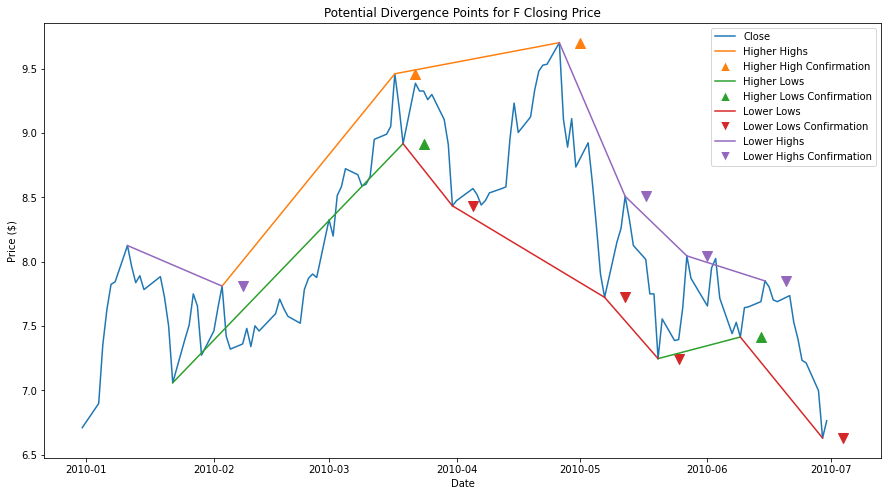

In [25]:
from datetime import timedelta

close = data['Close'].values
dates = data.index

order = 5
K = 2

hh = getHigherHighs(close, order, K)
hl = getHigherLows(close, order, K)
ll = getLowerLows(close, order, K)
lh = getLowerHighs(close, order, K)

plt.figure(figsize=(15, 8))
plt.plot(data['Close'])
_ = [plt.plot(dates[i], close[i], c=colors[1]) for i in hh]
_ = [plt.plot(dates[i], close[i], c=colors[2]) for i in hl]
_ = [plt.plot(dates[i], close[i], c=colors[3]) for i in ll]
_ = [plt.plot(dates[i], close[i], c=colors[4]) for i in lh]

_ = [plt.scatter(dates[i[-1]] + timedelta(order), close[i[-1]], 
    c=colors[1], marker='^', s=100) for i in hh]
_ = [plt.scatter(dates[i[-1]] + timedelta(order), close[i[-1]], 
    c=colors[2], marker='^', s=100) for i in hl]
_ = [plt.scatter(dates[i[-1]] + timedelta(order), close[i[-1]], 
    c=colors[3], marker='v', s=100) for i in ll]
_ = [plt.scatter(dates[i[-1]] + timedelta(order), close[i[-1]],
    c=colors[4], marker='v', s=100) for i in lh]
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title(f'Potential Divergence Points for {ticker} Closing Price')
legend_elements = [
  Line2D([0], [0], color=colors[0], label='Close'),
  Line2D([0], [0], color=colors[1], label='Higher Highs'),
  Line2D([0], [0], color='w',  marker='^',
         markersize=10,
         markerfacecolor=colors[1],
         label='Higher High Confirmation'),
  Line2D([0], [0], color=colors[2], label='Higher Lows'),
  Line2D([0], [0], color='w',  marker='^',
         markersize=10,
         markerfacecolor=colors[2],
         label='Higher Lows Confirmation'),
  Line2D([0], [0], color=colors[3], label='Lower Lows'),
  Line2D([0], [0], color='w',  marker='v',
         markersize=10,
         markerfacecolor=colors[3],
         label='Lower Lows Confirmation'),
  Line2D([0], [0], color=colors[4], label='Lower Highs'),
  Line2D([0], [0], color='w',  marker='v',
         markersize=10,
         markerfacecolor=colors[4],
         label='Lower Highs Confirmation')
]
plt.legend(handles=legend_elements)
plt.show()

These extrema can be traded in a variety of ways. We can use these as a proxy for momentum by taking the slope of the extrema one way or another. This slope then could be used to rank-order securities by their momentum to buy the highest momentum stocks, or those that are above a given threshold.

Many traders look at applying these extrema to both price and the indicator. If the price makes higher highs and the indicator makes lower highs, then we have a divergence on our hands! We can test these scenarios by applying the exact same functions above to RSI, Stochastic Oscillators, and so forth to build more complex strategies.

We can also use these rules for confirmation of trend. Maybe there's a reliable signal if both RSI and price make higher highs together?

Of course, we just used these functions on the closing price, but there's no reason you couldn't also apply them the open, high, or low for your bars.

All of this can get very complex very quickly. We're building a platform to allow you to easily test your ideas without coding. You can run your models in an event-driven backtest on professional quality data, get all of your stats, and deploy your model to the market with the click of a button. Just drop your email into the box below to get alerts when we go live!

